In [1]:
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

In [2]:
# declarations
out_dir = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_t3_s10_26022020/sim_samples/"

readlen = 101

num_tissues = 3
num_samples = 10

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

In [64]:
# containers
no_sim_detected_real = [] # transcripts identified by each method not in real simulated data (real gff only)
no_sim_detected_splicing = []
no_sim_detected_intronic = []
no_sim_detected_intergenic = []
no_sim_detected_all = [] # transcripts identified by each method not in real simulated data (all gff only)

sim_undetected_no_real = []
sim_undetected_no_splicing = []
sim_undetected_no_intronic = []
sim_undetected_no_intergenic = []
sim_undetected_no_all = [] # transcripts identified by each method in real but not all

detected_fold_splicing = [] # fold change in expression for each method
detected_fold_intronic = []
detected_fold_intergenic = []
detected_fold_all = []

detected_r_real = []
detected_r_splicing = []
detected_r_intronic = []
detected_r_intergenic = []
detected_r_all = []

In [65]:
# violin plot of log fold changes
# null hypothesis is that there is no change in the expression of transcripts when noise is introduced
# compute fold change between experimental conditions (real vs real with different types of noise)
# for each tool - visualize as a series of violin plots
for tissue_num in range(num_tissues):
    for sample_num in range(num_samples):
        real_df = pd.read_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".res")
        splicing_df = pd.read_csv(out_dir+"real_splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".res")
        intronic_df = pd.read_csv(out_dir+"real_intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".res")
        intergenic_df = pd.read_csv(out_dir+"real_intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".res")
        all_df = pd.read_csv(out_dir+"all.t"+str(tissue_num)+"_s"+str(sample_num)+".res")
        
        real_df["sim_cov"] = (readlen*real_df["sim_nreads"])/real_df["elen"]
        splicing_df["sim_cov"] = (readlen*splicing_df["sim_nreads"])/splicing_df["elen"]
        intronic_df["sim_cov"] = (readlen*intronic_df["sim_nreads"])/intronic_df["elen"]
        intergenic_df["sim_cov"] = (readlen*intergenic_df["sim_nreads"])/intergenic_df["elen"]
        all_df["sim_cov"] = (readlen*all_df["sim_nreads"])/all_df["elen"]
        
        # merge and compute fold_change in TPM
        merge_df = real_df[["tid","sim_nreads","sim_cov","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]].merge(splicing_df[["tid","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]],on="tid",how="inner")
        merge_df = merge_df.merge(intronic_df[["tid","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]],on="tid",how="inner")
        merge_df = merge_df.merge(intergenic_df[["tid","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]],on="tid",how="inner")
        merge_df = merge_df.merge(all_df[["tid","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]],on="tid",how="inner")
        assert len(merge_df)==len(real_df),"lost transcripts during merge"
        merge_df.columns = ["tid",
                            "sim_nreads",
                            "sim_cov",
                            "strg_tpm_real",
                            "strg_nreads_real",
                            "slmn_tpm_real",
                            "slmn_nreads_real",
                            "klst_tpm_real",
                            "klst_nreads_real",
                            "strg_tpm_splicing",
                            "strg_nreads_splicing",
                            "slmn_tpm_splicing",
                            "slmn_nreads_splicing",
                            "klst_tpm_splicing",
                            "klst_nreads_splicing",
                            "strg_tpm_intronic",
                            "strg_nreads_intronic",
                            "slmn_tpm_intronic",
                            "slmn_nreads_intronic",
                            "klst_tpm_intronic",
                            "klst_nreads_intronic",
                            "strg_tpm_intergenic",
                            "strg_nreads_intergenic",
                            "slmn_tpm_intergenic",
                            "slmn_nreads_intergenic",
                            "klst_tpm_intergenic",
                            "klst_nreads_intergenic",
                            "strg_tpm_all",
                            "strg_nreads_all",
                            "slmn_tpm_all",
                            "slmn_nreads_all",
                            "klst_tpm_all",
                            "klst_nreads_all"]
        
        # first how many transcripts are identified by each method that were not in the sample
        no_sim_detected_real.append(list())
        no_sim_detected_real[-1].append(merge_df[(merge_df["strg_tpm_real"]>0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_real"]].reset_index(drop=True))
        no_sim_detected_real[-1].append(merge_df[(merge_df["slmn_tpm_real"]>0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_real"]].reset_index(drop=True))
        no_sim_detected_real[-1].append(merge_df[(merge_df["klst_tpm_real"]>0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_real"]].reset_index(drop=True))

        no_sim_detected_splicing.append(list())
        no_sim_detected_splicing[-1].append(merge_df[(merge_df["strg_tpm_splicing"]>0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_splicing"]].reset_index(drop=True))
        no_sim_detected_splicing[-1].append(merge_df[(merge_df["slmn_tpm_splicing"]>0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_splicing"]].reset_index(drop=True))
        no_sim_detected_splicing[-1].append(merge_df[(merge_df["klst_tpm_splicing"]>0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_splicing"]].reset_index(drop=True))
        
        no_sim_detected_intronic.append(list())
        no_sim_detected_intronic[-1].append(merge_df[(merge_df["strg_tpm_intronic"]>0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_intronic"]].reset_index(drop=True))
        no_sim_detected_intronic[-1].append(merge_df[(merge_df["slmn_tpm_intronic"]>0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_intronic"]].reset_index(drop=True))
        no_sim_detected_intronic[-1].append(merge_df[(merge_df["klst_tpm_intronic"]>0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_intronic"]].reset_index(drop=True))
        
        no_sim_detected_intergenic.append(list())
        no_sim_detected_intergenic[-1].append(merge_df[(merge_df["strg_tpm_intergenic"]>0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_intergenic"]].reset_index(drop=True))
        no_sim_detected_intergenic[-1].append(merge_df[(merge_df["slmn_tpm_intergenic"]>0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_intergenic"]].reset_index(drop=True))
        no_sim_detected_intergenic[-1].append(merge_df[(merge_df["klst_tpm_intergenic"]>0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_intergenic"]].reset_index(drop=True))
        
        no_sim_detected_all.append(list())
        no_sim_detected_all[-1].append(merge_df[(merge_df["strg_tpm_all"]>0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_all"]].reset_index(drop=True))
        no_sim_detected_all[-1].append(merge_df[(merge_df["slmn_tpm_all"]>0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_all"]].reset_index(drop=True))
        no_sim_detected_all[-1].append(merge_df[(merge_df["klst_tpm_all"]>0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_all"]].reset_index(drop=True))


        # next get information about those that were not identified at all (but were present in the real)
        sim_undetected_no_real.append(list())
        sim_undetected_no_real[-1].append(merge_df[(merge_df["strg_tpm_real"]==0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_real","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_real[-1].append(merge_df[(merge_df["slmn_tpm_real"]==0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_real","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_real[-1].append(merge_df[(merge_df["klst_tpm_real"]==0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_real","sim_cov"]].reset_index(drop=True))

        sim_undetected_no_splicing.append(list())
        sim_undetected_no_splicing[-1].append(merge_df[(merge_df["strg_tpm_splicing"]==0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_splicing","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_splicing[-1].append(merge_df[(merge_df["slmn_tpm_splicing"]==0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_splicing","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_splicing[-1].append(merge_df[(merge_df["klst_tpm_splicing"]==0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_splicing","sim_cov"]].reset_index(drop=True))

        sim_undetected_no_intronic.append(list())
        sim_undetected_no_intronic[-1].append(merge_df[(merge_df["strg_tpm_intronic"]==0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_intronic","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_intronic[-1].append(merge_df[(merge_df["slmn_tpm_intronic"]==0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_intronic","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_intronic[-1].append(merge_df[(merge_df["klst_tpm_intronic"]==0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_intronic","sim_cov"]].reset_index(drop=True))

        sim_undetected_no_intergenic.append(list())
        sim_undetected_no_intergenic[-1].append(merge_df[(merge_df["strg_tpm_intergenic"]==0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_intergenic","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_intergenic[-1].append(merge_df[(merge_df["slmn_tpm_intergenic"]==0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_intergenic","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_intergenic[-1].append(merge_df[(merge_df["klst_tpm_intergenic"]==0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_intergenic","sim_cov"]].reset_index(drop=True))

        sim_undetected_no_all.append(list())
        sim_undetected_no_all[-1].append(merge_df[(merge_df["strg_tpm_all"]==0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_all","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_all[-1].append(merge_df[(merge_df["slmn_tpm_all"]==0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_all","sim_cov"]].reset_index(drop=True))
        sim_undetected_no_all[-1].append(merge_df[(merge_df["klst_tpm_all"]==0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_all","sim_cov"]].reset_index(drop=True))


        # next get the fold change for everything that is left
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_tpm_real"]>0)&(merge_df["strg_tpm_splicing"]>0)][["tid","strg_tpm_real","strg_tpm_splicing"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_tpm_real"]>0)&(merge_df["slmn_tpm_splicing"]>0)][["tid","slmn_tpm_real","slmn_tpm_splicing"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_tpm_real"]>0)&(merge_df["klst_tpm_splicing"]>0)][["tid","klst_tpm_real","klst_tpm_splicing"]].reset_index(drop=True)
        strg_df["strg_fold_splicing"] = strg_df["strg_tpm_splicing"]/strg_df["strg_tpm_real"]
        slmn_df["slmn_fold_splicing"] = slmn_df["slmn_tpm_splicing"]/slmn_df["slmn_tpm_real"]
        klst_df["klst_fold_splicing"] = klst_df["klst_tpm_splicing"]/klst_df["klst_tpm_real"]
        detected_fold_splicing.append(list())
        detected_fold_splicing[-1].append(strg_df[["tid","strg_fold_splicing"]])
        detected_fold_splicing[-1].append(slmn_df[["tid","slmn_fold_splicing"]])
        detected_fold_splicing[-1].append(klst_df[["tid","klst_fold_splicing"]])

        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_tpm_real"]>0)&(merge_df["strg_tpm_intronic"]>0)][["tid","strg_tpm_real","strg_tpm_intronic"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_tpm_real"]>0)&(merge_df["slmn_tpm_intronic"]>0)][["tid","slmn_tpm_real","slmn_tpm_intronic"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_tpm_real"]>0)&(merge_df["klst_tpm_intronic"]>0)][["tid","klst_tpm_real","klst_tpm_intronic"]].reset_index(drop=True)
        strg_df["strg_fold_intronic"] = strg_df["strg_tpm_intronic"]/strg_df["strg_tpm_real"]
        slmn_df["slmn_fold_intronic"] = slmn_df["slmn_tpm_intronic"]/slmn_df["slmn_tpm_real"]
        klst_df["klst_fold_intronic"] = klst_df["klst_tpm_intronic"]/klst_df["klst_tpm_real"]
        detected_fold_intronic.append(list())
        detected_fold_intronic[-1].append(strg_df[["tid","strg_fold_intronic"]])
        detected_fold_intronic[-1].append(slmn_df[["tid","slmn_fold_intronic"]])
        detected_fold_intronic[-1].append(klst_df[["tid","klst_fold_intronic"]])

        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_tpm_real"]>0)&(merge_df["strg_tpm_intergenic"]>0)][["tid","strg_tpm_real","strg_tpm_intergenic"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_tpm_real"]>0)&(merge_df["slmn_tpm_intergenic"]>0)][["tid","slmn_tpm_real","slmn_tpm_intergenic"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_tpm_real"]>0)&(merge_df["klst_tpm_intergenic"]>0)][["tid","klst_tpm_real","klst_tpm_intergenic"]].reset_index(drop=True)
        strg_df["strg_fold_intergenic"] = strg_df["strg_tpm_intergenic"]/strg_df["strg_tpm_real"]
        slmn_df["slmn_fold_intergenic"] = slmn_df["slmn_tpm_intergenic"]/slmn_df["slmn_tpm_real"]
        klst_df["klst_fold_intergenic"] = klst_df["klst_tpm_intergenic"]/klst_df["klst_tpm_real"]
        detected_fold_intergenic.append(list())
        detected_fold_intergenic[-1].append(strg_df[["tid","strg_fold_intergenic"]])
        detected_fold_intergenic[-1].append(slmn_df[["tid","slmn_fold_intergenic"]])
        detected_fold_intergenic[-1].append(klst_df[["tid","klst_fold_intergenic"]])

        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_tpm_real"]>0)&(merge_df["strg_tpm_all"]>0)][["tid","strg_tpm_real","strg_tpm_all"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_tpm_real"]>0)&(merge_df["slmn_tpm_all"]>0)][["tid","slmn_tpm_real","slmn_tpm_all"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_tpm_real"]>0)&(merge_df["klst_tpm_all"]>0)][["tid","klst_tpm_real","klst_tpm_all"]].reset_index(drop=True)
        strg_df["strg_fold_all"] = strg_df["strg_tpm_all"]/strg_df["strg_tpm_real"]
        slmn_df["slmn_fold_all"] = slmn_df["slmn_tpm_all"]/slmn_df["slmn_tpm_real"]
        klst_df["klst_fold_all"] = klst_df["klst_tpm_all"]/klst_df["klst_tpm_real"]
        detected_fold_all.append(list())
        detected_fold_all[-1].append(strg_df[["tid","strg_fold_all"]])
        detected_fold_all[-1].append(slmn_df[["tid","slmn_fold_all"]])
        detected_fold_all[-1].append(klst_df[["tid","klst_fold_all"]])
        
        
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_nreads_real"]>0)][["tid","sim_nreads","strg_nreads_real"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_nreads_real"]>0)][["tid","sim_nreads","slmn_nreads_real"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_nreads_real"]>0)][["tid","sim_nreads","klst_nreads_real"]].reset_index(drop=True)
        detected_r_real.append(list())
        detected_r_real[-1].append(stats.linregress(strg_df["sim_nreads"],strg_df["strg_nreads_real"]).rvalue)
        detected_r_real[-1].append(stats.linregress(slmn_df["sim_nreads"],slmn_df["slmn_nreads_real"]).rvalue)
        detected_r_real[-1].append(stats.linregress(klst_df["sim_nreads"],klst_df["klst_nreads_real"]).rvalue)
        
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_nreads_splicing"]>0)][["tid","sim_nreads","strg_nreads_splicing"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_nreads_splicing"]>0)][["tid","sim_nreads","slmn_nreads_splicing"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_nreads_splicing"]>0)][["tid","sim_nreads","klst_nreads_splicing"]].reset_index(drop=True)
        detected_r_splicing.append(list())
        detected_r_splicing[-1].append(stats.linregress(strg_df["sim_nreads"],strg_df["strg_nreads_splicing"]).rvalue)
        detected_r_splicing[-1].append(stats.linregress(slmn_df["sim_nreads"],slmn_df["slmn_nreads_splicing"]).rvalue)
        detected_r_splicing[-1].append(stats.linregress(klst_df["sim_nreads"],klst_df["klst_nreads_splicing"]).rvalue)
        
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_nreads_intronic"]>0)][["tid","sim_nreads","strg_nreads_intronic"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_nreads_intronic"]>0)][["tid","sim_nreads","slmn_nreads_intronic"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_nreads_intronic"]>0)][["tid","sim_nreads","klst_nreads_intronic"]].reset_index(drop=True)
        detected_r_intronic.append(list())
        detected_r_intronic[-1].append(stats.linregress(strg_df["sim_nreads"],strg_df["strg_nreads_intronic"]).rvalue)
        detected_r_intronic[-1].append(stats.linregress(slmn_df["sim_nreads"],slmn_df["slmn_nreads_intronic"]).rvalue)
        detected_r_intronic[-1].append(stats.linregress(klst_df["sim_nreads"],klst_df["klst_nreads_intronic"]).rvalue)
        
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_nreads_intergenic"]>0)][["tid","sim_nreads","strg_nreads_intergenic"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_nreads_intergenic"]>0)][["tid","sim_nreads","slmn_nreads_intergenic"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_nreads_intergenic"]>0)][["tid","sim_nreads","klst_nreads_intergenic"]].reset_index(drop=True)
        detected_r_intergenic.append(list())
        detected_r_intergenic[-1].append(stats.linregress(strg_df["sim_nreads"],strg_df["strg_nreads_intergenic"]).rvalue)
        detected_r_intergenic[-1].append(stats.linregress(slmn_df["sim_nreads"],slmn_df["slmn_nreads_intergenic"]).rvalue)
        detected_r_intergenic[-1].append(stats.linregress(klst_df["sim_nreads"],klst_df["klst_nreads_intergenic"]).rvalue)
        
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_nreads_all"]>0)][["tid","sim_nreads","strg_nreads_all"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_nreads_all"]>0)][["tid","sim_nreads","slmn_nreads_all"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_nreads_all"]>0)][["tid","sim_nreads","klst_nreads_all"]].reset_index(drop=True)
        detected_r_all.append(list())
        detected_r_all[-1].append(stats.linregress(strg_df["sim_nreads"],strg_df["strg_nreads_all"]).rvalue)
        detected_r_all[-1].append(stats.linregress(slmn_df["sim_nreads"],slmn_df["slmn_nreads_all"]).rvalue)
        detected_r_all[-1].append(stats.linregress(klst_df["sim_nreads"],klst_df["klst_nreads_all"]).rvalue)

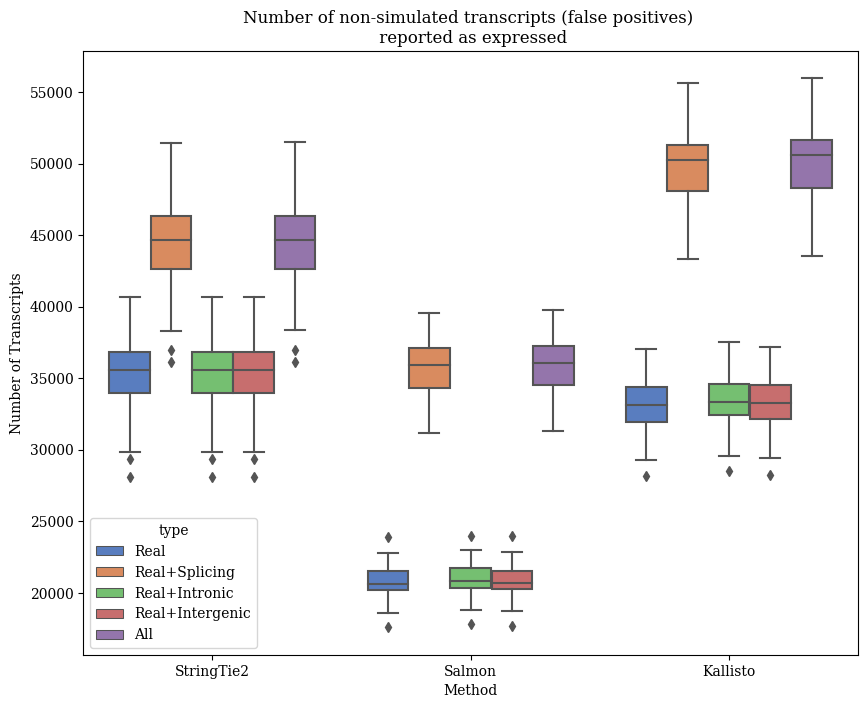

In [66]:
# plot number of transcripts in each group
num_txs_strg_real = []
num_txs_slmn_real = []
num_txs_klst_real = []

num_txs_strg_splicing = []
num_txs_slmn_splicing = []
num_txs_klst_splicing = []

num_txs_strg_intronic = []
num_txs_slmn_intronic = []
num_txs_klst_intronic = []

num_txs_strg_intergenic = []
num_txs_slmn_intergenic = []
num_txs_klst_intergenic = []

num_txs_strg_all = []
num_txs_slmn_all = []
num_txs_klst_all = []

for i in range(len(no_sim_detected_real)):
    num_txs_strg_real.append(len(no_sim_detected_real[i][0]))
    num_txs_slmn_real.append(len(no_sim_detected_real[i][1]))
    num_txs_klst_real.append(len(no_sim_detected_real[i][2]))
    
    num_txs_strg_splicing.append(len(no_sim_detected_splicing[i][0]))
    num_txs_slmn_splicing.append(len(no_sim_detected_splicing[i][1]))
    num_txs_klst_splicing.append(len(no_sim_detected_splicing[i][2]))
    
    num_txs_strg_intronic.append(len(no_sim_detected_intronic[i][0]))
    num_txs_slmn_intronic.append(len(no_sim_detected_intronic[i][1]))
    num_txs_klst_intronic.append(len(no_sim_detected_intronic[i][2]))
    
    num_txs_strg_intergenic.append(len(no_sim_detected_intergenic[i][0]))
    num_txs_slmn_intergenic.append(len(no_sim_detected_intergenic[i][1]))
    num_txs_klst_intergenic.append(len(no_sim_detected_intergenic[i][2]))
    
    num_txs_strg_all.append(len(no_sim_detected_all[i][0]))
    num_txs_slmn_all.append(len(no_sim_detected_all[i][1]))
    num_txs_klst_all.append(len(no_sim_detected_all[i][2]))
    
tmp = pd.DataFrame(num_txs_strg_real,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real"
df = tmp.copy(deep=True)
tmp = pd.DataFrame(num_txs_strg_splicing,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_strg_intronic,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_strg_intergenic,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_strg_all,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

tmp = pd.DataFrame(num_txs_slmn_real,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "Real"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_splicing,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_intronic,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_intergenic,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_all,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

tmp = pd.DataFrame(num_txs_klst_real,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_splicing,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_intronic,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_intergenic,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_all,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

df.reset_index(drop=True)

fig = plt.figure(figsize=(10,8),dpi=100)
ax = sns.boxplot(x="method",y="num_txs",hue="type",data=df,palette="muted")
ax.set_title("Number of non-simulated transcripts (false positives) \n reported as expressed")
ax.set_xlabel("Method")
ax.set_ylabel("Number of Transcripts")
plt.show()

In [67]:
avg_strg_real = round(df[(df["method"]=="StringTie2")&(df["type"]=="Real")]["num_txs"].mean())
avg_slmn_real = round(df[(df["method"]=="Salmon")&(df["type"]=="Real")]["num_txs"].mean())
avg_klst_real = round(df[(df["method"]=="Kallisto")&(df["type"]=="Real")]["num_txs"].mean())

sd_strg_real = round(df[(df["method"]=="StringTie2")&(df["type"]=="Real")]["num_txs"].std())
sd_slmn_real = round(df[(df["method"]=="Salmon")&(df["type"]=="Real")]["num_txs"].std())
sd_klst_real = round(df[(df["method"]=="Kallisto")&(df["type"]=="Real")]["num_txs"].std())

for tp in set(df["type"]):
    if not tp=="Real":
        print("\n==== "+tp+" ====\n")
        avg_strg_tp = round(df[(df["method"]=="StringTie2")&(df["type"]==tp)]["num_txs"].mean())
        avg_slmn_tp = round(df[(df["method"]=="Salmon")&(df["type"]==tp)]["num_txs"].mean())
        avg_klst_tp = round(df[(df["method"]=="Kallisto")&(df["type"]==tp)]["num_txs"].mean())
        
        sd_strg_tp = round(df[(df["method"]=="StringTie2")&(df["type"]==tp)]["num_txs"].std())
        sd_slmn_tp = round(df[(df["method"]=="Salmon")&(df["type"]==tp)]["num_txs"].std())
        sd_klst_tp = round(df[(df["method"]=="Kallisto")&(df["type"]==tp)]["num_txs"].std())
        
        ch_strg = round(((avg_strg_tp-avg_strg_real)/avg_strg_real)*100,2)
        ch_slmn = round(((avg_slmn_tp-avg_slmn_real)/avg_slmn_real)*100,2)
        ch_klst = round(((avg_klst_tp-avg_klst_real)/avg_klst_real)*100,2)
        
        print("StringTie2: %change: "+str(ch_strg)+" : real: "+str(avg_strg_real)+" ; "+str(sd_strg_real)+" : new: "+str(avg_strg_tp)+" ; "+str(sd_strg_tp))
        print("Salmon: %change: "+str(ch_slmn)+" : real: "+str(avg_slmn_real)+" ; "+str(sd_slmn_real)+" : new: "+str(avg_slmn_tp)+" ; "+str(sd_slmn_tp))
        print("Kallisto: %change: "+str(ch_klst)+" : real: "+str(avg_klst_real)+" ; "+str(sd_klst_real)+" : new: "+str(avg_klst_tp)+" ; "+str(sd_klst_tp))


==== Real+Intergenic ====

StringTie2: %change: 0.01 : real: 35186 ; 2837 : new: 35190 ; 2837
Salmon: %change: 0.41 : real: 20700 ; 1330 : new: 20784 ; 1326
Kallisto: %change: 0.41 : real: 32921 ; 1984 : new: 33057 ; 1990

==== Real+Splicing ====

StringTie2: %change: 25.92 : real: 35186 ; 2837 : new: 44307 ; 3568
Salmon: %change: 72.05 : real: 20700 ; 1330 : new: 35615 ; 2302
Kallisto: %change: 51.04 : real: 32921 ; 1984 : new: 49724 ; 2964

==== All ====

StringTie2: %change: 25.95 : real: 35186 ; 2837 : new: 44317 ; 3569
Salmon: %change: 72.81 : real: 20700 ; 1330 : new: 35772 ; 2328
Kallisto: %change: 51.94 : real: 32921 ; 1984 : new: 50020 ; 3001

==== Real+Intronic ====

StringTie2: %change: 0.03 : real: 35186 ; 2837 : new: 35197 ; 2837
Salmon: %change: 1.04 : real: 20700 ; 1330 : new: 20916 ; 1325
Kallisto: %change: 1.11 : real: 32921 ; 1984 : new: 33286 ; 1997


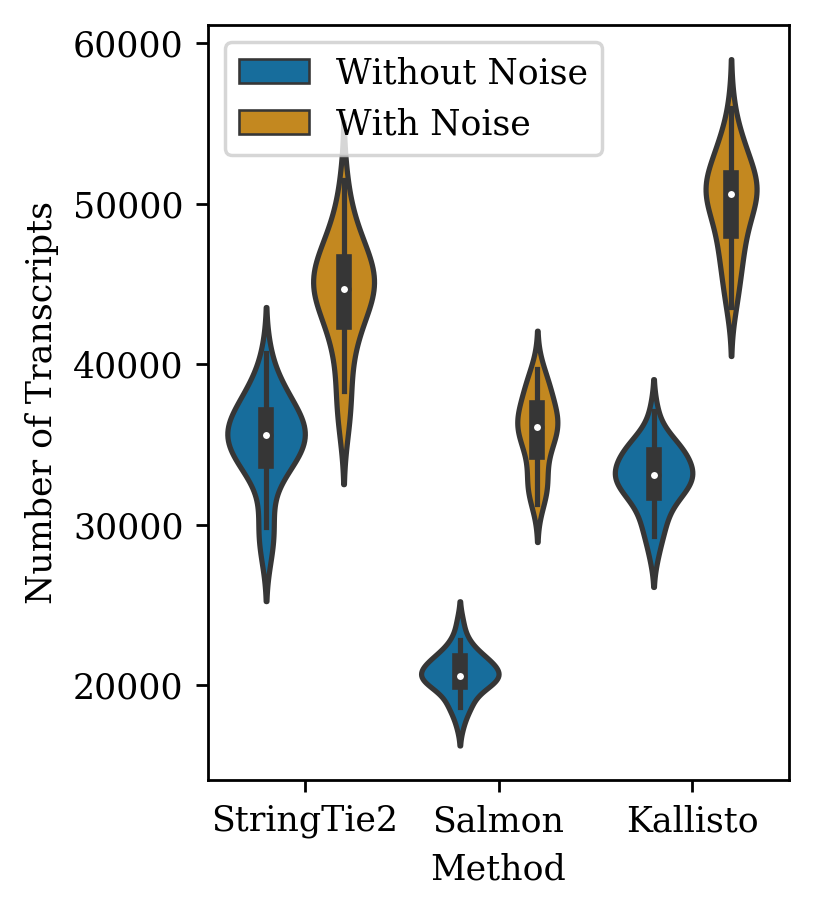

In [68]:
sub_df = df[df["type"].isin(["Real","All"])].reset_index(drop=True)
sub_df["type"]=np.where(sub_df["type"]=="Real","Without Noise","With Noise")
fig = plt.figure(figsize=(3,4),dpi=250)
ax = sns.violinplot(x="method",y="num_txs",hue="type",data=sub_df,palette="colorblind")
# ax.set_title("False Positive Rate in the Absence and \n Presence of Noisy Transcription")
ax.set_xlabel("Method")
ax.set_ylabel("Number of Transcripts")
legend = plt.legend()
plt.show()

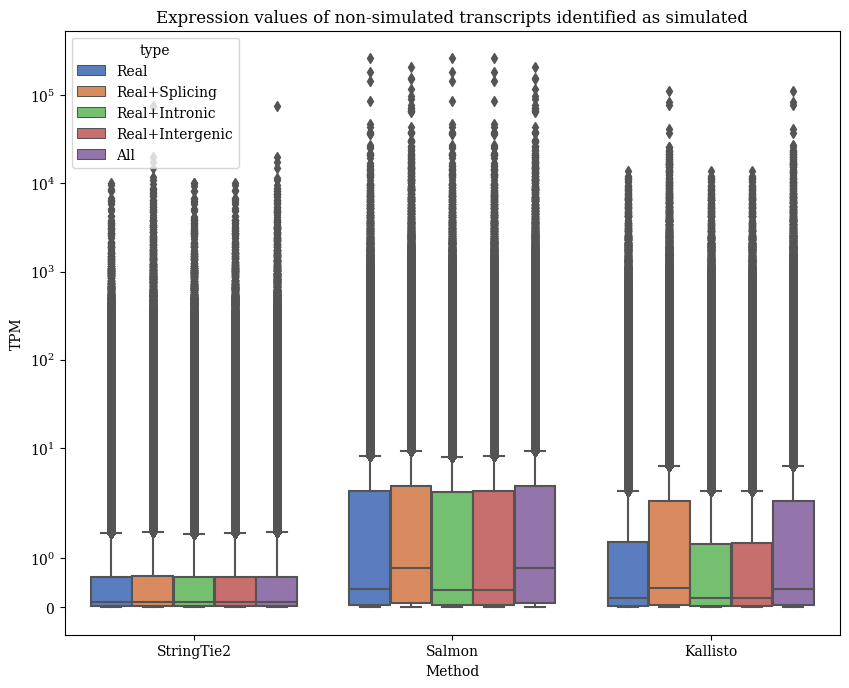

In [69]:
# plot expression values in each group
tpm_strg_real = []
tpm_slmn_real = []
tpm_klst_real = []

tpm_strg_splicing = []
tpm_slmn_splicing = []
tpm_klst_splicing = []

tpm_strg_intronic = []
tpm_slmn_intronic = []
tpm_klst_intronic = []

tpm_strg_intergenic = []
tpm_slmn_intergenic = []
tpm_klst_intergenic = []

tpm_strg_all = []
tpm_slmn_all = []
tpm_klst_all = []

for i in range(len(no_sim_detected_real)):
    tpm_strg_real.extend(no_sim_detected_real[i][0]["strg_tpm_real"].tolist())
    tpm_slmn_real.extend(no_sim_detected_real[i][1]["slmn_tpm_real"].tolist())
    tpm_klst_real.extend(no_sim_detected_real[i][2]["klst_tpm_real"].tolist())
    
    tpm_strg_splicing.extend(no_sim_detected_splicing[i][0]["strg_tpm_splicing"].tolist())
    tpm_slmn_splicing.extend(no_sim_detected_splicing[i][1]["slmn_tpm_splicing"].tolist())
    tpm_klst_splicing.extend(no_sim_detected_splicing[i][2]["klst_tpm_splicing"].tolist())
    
    tpm_strg_intronic.extend(no_sim_detected_intronic[i][0]["strg_tpm_intronic"].tolist())
    tpm_slmn_intronic.extend(no_sim_detected_intronic[i][1]["slmn_tpm_intronic"].tolist())
    tpm_klst_intronic.extend(no_sim_detected_intronic[i][2]["klst_tpm_intronic"].tolist())
    
    tpm_strg_intergenic.extend(no_sim_detected_intergenic[i][0]["strg_tpm_intergenic"].tolist())
    tpm_slmn_intergenic.extend(no_sim_detected_intergenic[i][1]["slmn_tpm_intergenic"].tolist())
    tpm_klst_intergenic.extend(no_sim_detected_intergenic[i][2]["klst_tpm_intergenic"].tolist())
    
    tpm_strg_all.extend(no_sim_detected_all[i][0]["strg_tpm_all"].tolist())
    tpm_slmn_all.extend(no_sim_detected_all[i][1]["slmn_tpm_all"].tolist())
    tpm_klst_all.extend(no_sim_detected_all[i][2]["klst_tpm_all"].tolist())
    
tmp = pd.DataFrame(tpm_strg_real,columns=["tpm"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real"
df_tpm = tmp.copy(deep=True)
tmp = pd.DataFrame(tpm_strg_splicing,columns=["tpm"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Splicing"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_strg_intronic,columns=["tpm"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intronic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_strg_intergenic,columns=["tpm"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intergenic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_strg_all,columns=["tpm"])
tmp["method"] = "StringTie2"
tmp["type"] = "All"
df_tpm = pd.concat([df_tpm,tmp],axis=0)

tmp = pd.DataFrame(tpm_slmn_real,columns=["tpm"])
tmp["method"] = "Salmon"
tmp["type"] = "Real"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_slmn_splicing,columns=["tpm"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Splicing"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_slmn_intronic,columns=["tpm"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intronic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_slmn_intergenic,columns=["tpm"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intergenic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_slmn_all,columns=["tpm"])
tmp["method"] = "Salmon"
tmp["type"] = "All"
df_tpm = pd.concat([df_tpm,tmp],axis=0)

tmp = pd.DataFrame(tpm_klst_real,columns=["tpm"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_klst_splicing,columns=["tpm"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Splicing"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_klst_intronic,columns=["tpm"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intronic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_klst_intergenic,columns=["tpm"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intergenic"
df_tpm = pd.concat([df_tpm,tmp],axis=0)
tmp = pd.DataFrame(tpm_klst_all,columns=["tpm"])
tmp["method"] = "Kallisto"
tmp["type"] = "All"
df_tpm = pd.concat([df_tpm,tmp],axis=0)

df_tpm.reset_index(drop=True)

fig = plt.figure(figsize=(10,8),dpi=100)
ax = sns.boxplot(x="method",y="tpm",hue="type",data=df_tpm,palette="muted")
ax.set_yscale("symlog")
ax.set_title("Expression values of non-simulated transcripts identified as simulated")
ax.set_xlabel("Method")
ax.set_ylabel("TPM")
plt.show()

In [70]:
avg_strg_real = df_tpm[(df_tpm["method"]=="StringTie2")&(df_tpm["type"]=="Real")]["tpm"].median()
avg_slmn_real = df_tpm[(df_tpm["method"]=="Salmon")&(df_tpm["type"]=="Real")]["tpm"].median()
avg_klst_real = df_tpm[(df_tpm["method"]=="Kallisto")&(df_tpm["type"]=="Real")]["tpm"].median()

for tp in set(df_tpm["type"]):
    if not tp=="Real":
        print("\n==== "+tp+" ====\n")
        avg_strg_tp = df_tpm[(df_tpm["method"]=="StringTie2")&(df_tpm["type"]==tp)]["tpm"].median()
        avg_slmn_tp = df_tpm[(df_tpm["method"]=="Salmon")&(df_tpm["type"]==tp)]["tpm"].median()
        avg_klst_tp = df_tpm[(df_tpm["method"]=="Kallisto")&(df_tpm["type"]==tp)]["tpm"].median()
        
        ch_strg = round(((avg_strg_tp-avg_strg_real)/avg_strg_real)*100,2)
        ch_slmn = round(((avg_slmn_tp-avg_slmn_real)/avg_slmn_real)*100,2)
        ch_klst = round(((avg_klst_tp-avg_klst_real)/avg_klst_real)*100,2)
        
        print("StringTie2: %change: "+str(ch_strg)+" : real: "+str(round(avg_strg_real,2))+" : new: "+str(round(avg_strg_tp,2)))
        print("Salmon: %change: "+str(ch_slmn)+" : real: "+str(round(avg_slmn_real,2))+" : new: "+str(round(avg_slmn_tp,2)))
        print("Kallisto: %change: "+str(ch_klst)+" : real: "+str(round(avg_klst_real,2))+" : new: "+str(round(avg_klst_tp,2)))


==== Real+Intergenic ====

StringTie2: %change: -0.05 : real: 0.11 : new: 0.11
Salmon: %change: -0.91 : real: 0.37 : new: 0.36
Kallisto: %change: -0.58 : real: 0.19 : new: 0.18

==== Real+Splicing ====

StringTie2: %change: 0.98 : real: 0.11 : new: 0.11
Salmon: %change: 121.37 : real: 0.37 : new: 0.81
Kallisto: %change: 108.02 : real: 0.19 : new: 0.39

==== All ====

StringTie2: %change: 0.08 : real: 0.11 : new: 0.11
Salmon: %change: 119.41 : real: 0.37 : new: 0.8
Kallisto: %change: 105.49 : real: 0.19 : new: 0.38

==== Real+Intronic ====

StringTie2: %change: -1.21 : real: 0.11 : new: 0.11
Salmon: %change: -2.49 : real: 0.37 : new: 0.36
Kallisto: %change: -1.15 : real: 0.19 : new: 0.18


In [10]:
for tp in set(df_tpm["type"]):
    print("\n==== "+tp+" ====\n")
    strg_tp = len(df_tpm[(df_tpm["method"]=="StringTie2")&(df_tpm["type"]==tp)&(df_tpm["tpm"]>1)]["tpm"])
    slmn_tp = len(df_tpm[(df_tpm["method"]=="Salmon")&(df_tpm["type"]==tp)&(df_tpm["tpm"]>1)]["tpm"])
    klst_tp = len(df_tpm[(df_tpm["method"]=="Kallisto")&(df_tpm["type"]==tp)&(df_tpm["tpm"]>1)]["tpm"])

    print("StringTie2: number FP >1TPM: "+str(strg_tp))
    print("Salmon: number FP >1TPM: "+str(slmn_tp))
    print("Kallisto: number FP >1TPM: "+str(klst_tp))


==== Real ====

StringTie2: number FP >1TPM: 205139
Salmon: number FP >1TPM: 246942
Kallisto: number FP >1TPM: 278434

==== Real+Intergenic ====

StringTie2: number FP >1TPM: 205197
Salmon: number FP >1TPM: 247223
Kallisto: number FP >1TPM: 278734

==== Real+Splicing ====

StringTie2: number FP >1TPM: 261075
Salmon: number FP >1TPM: 501471
Kallisto: number FP >1TPM: 565713

==== All ====

StringTie2: number FP >1TPM: 259766
Salmon: number FP >1TPM: 502305
Kallisto: number FP >1TPM: 566632

==== Real+Intronic ====

StringTie2: number FP >1TPM: 203845
Salmon: number FP >1TPM: 247714
Kallisto: number FP >1TPM: 279428


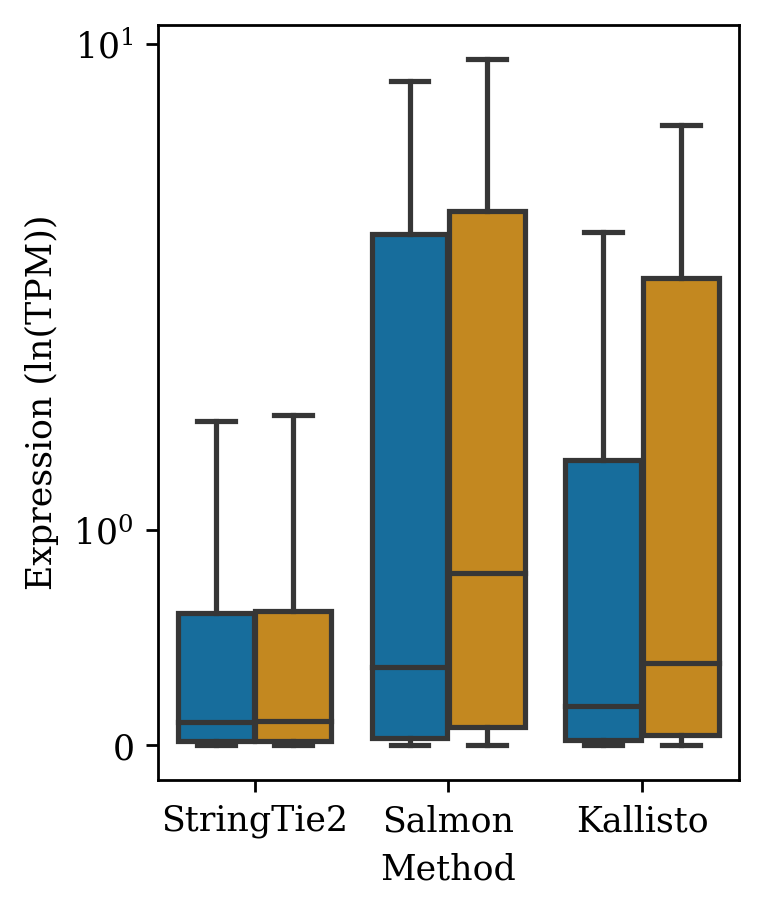

In [60]:
sub_df = df_tpm[df_tpm["type"].isin(["Real","All"])].reset_index(drop=True)
sub_df["type"]=np.where(sub_df["type"]=="Real","Without Noise","With Noise")
fig = plt.figure(figsize=(3,4),dpi=250)
ax = sns.boxplot(x="method",y="tpm",hue="type",data=sub_df,palette="colorblind",showfliers=False)
ax.set_yscale("symlog")
# ax.set_title("Estimated Expression of False Positives \n in the Absence and Presence of Noise")
ax.set_xlabel("Method")
ax.set_ylabel("Expression (ln(TPM))")
legend = ax.legend()
# plt.legend(loc='upper left')
ax.legend().remove()
plt.show()

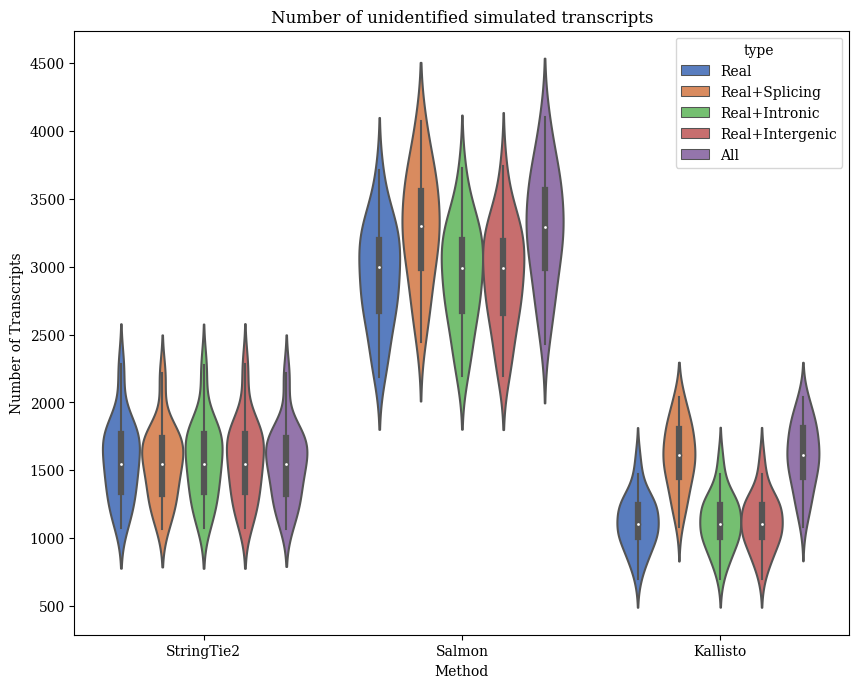

In [55]:
# plot the number of transcripts in each group
num_txs_strg_real = []
num_txs_slmn_real = []
num_txs_klst_real = []

num_txs_strg_splicing = []
num_txs_slmn_splicing = []
num_txs_klst_splicing = []

num_txs_strg_intronic = []
num_txs_slmn_intronic = []
num_txs_klst_intronic = []

num_txs_strg_intergenic = []
num_txs_slmn_intergenic = []
num_txs_klst_intergenic = []

num_txs_strg_all = []
num_txs_slmn_all = []
num_txs_klst_all = []

for i in range(len(sim_undetected_no_real)):
    num_txs_strg_real.append(len(sim_undetected_no_real[i][0]))
    num_txs_slmn_real.append(len(sim_undetected_no_real[i][1]))
    num_txs_klst_real.append(len(sim_undetected_no_real[i][2]))
    
    num_txs_strg_splicing.append(len(sim_undetected_no_splicing[i][0]))
    num_txs_slmn_splicing.append(len(sim_undetected_no_splicing[i][1]))
    num_txs_klst_splicing.append(len(sim_undetected_no_splicing[i][2]))
    
    num_txs_strg_intronic.append(len(sim_undetected_no_intronic[i][0]))
    num_txs_slmn_intronic.append(len(sim_undetected_no_intronic[i][1]))
    num_txs_klst_intronic.append(len(sim_undetected_no_intronic[i][2]))
    
    num_txs_strg_intergenic.append(len(sim_undetected_no_intergenic[i][0]))
    num_txs_slmn_intergenic.append(len(sim_undetected_no_intergenic[i][1]))
    num_txs_klst_intergenic.append(len(sim_undetected_no_intergenic[i][2]))
    
    num_txs_strg_all.append(len(sim_undetected_no_all[i][0]))
    num_txs_slmn_all.append(len(sim_undetected_no_all[i][1]))
    num_txs_klst_all.append(len(sim_undetected_no_all[i][2]))
    
tmp = pd.DataFrame(num_txs_strg_real,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real"
df = tmp.copy(deep=True)
tmp = pd.DataFrame(num_txs_strg_splicing,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_strg_intronic,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_strg_intergenic,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_strg_all,columns=["num_txs"])
tmp["method"] = "StringTie2"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

tmp = pd.DataFrame(num_txs_slmn_real,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "Real"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_splicing,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_intronic,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_intergenic,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_all,columns=["num_txs"])
tmp["method"] = "Salmon"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

tmp = pd.DataFrame(num_txs_klst_real,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_splicing,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_intronic,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_intergenic,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_all,columns=["num_txs"])
tmp["method"] = "Kallisto"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

df.reset_index(drop=True)

fig = plt.figure(figsize=(10,8),dpi=100)
ax = sns.violinplot(x="method",y="num_txs",hue="type",data=df,palette="muted")
ax.set_title("Number of unidentified simulated transcripts")
ax.set_xlabel("Method")
ax.set_ylabel("Number of Transcripts")
plt.show()

In [13]:
avg_strg_real = round(df[(df["method"]=="StringTie2")&(df["type"]=="Real")]["num_txs"].mean())
avg_slmn_real = round(df[(df["method"]=="Salmon")&(df["type"]=="Real")]["num_txs"].mean())
avg_klst_real = round(df[(df["method"]=="Kallisto")&(df["type"]=="Real")]["num_txs"].mean())

sd_strg_real = round(df[(df["method"]=="StringTie2")&(df["type"]=="Real")]["num_txs"].std())
sd_slmn_real = round(df[(df["method"]=="Salmon")&(df["type"]=="Real")]["num_txs"].std())
sd_klst_real = round(df[(df["method"]=="Kallisto")&(df["type"]=="Real")]["num_txs"].std())

for tp in set(df["type"]):
    if not tp=="Real":
        print("\n==== "+tp+" ====\n")
        avg_strg_tp = round(df[(df["method"]=="StringTie2")&(df["type"]==tp)]["num_txs"].mean())
        avg_slmn_tp = round(df[(df["method"]=="Salmon")&(df["type"]==tp)]["num_txs"].mean())
        avg_klst_tp = round(df[(df["method"]=="Kallisto")&(df["type"]==tp)]["num_txs"].mean())
        
        sd_strg_tp = round(df[(df["method"]=="StringTie2")&(df["type"]==tp)]["num_txs"].std())
        sd_slmn_tp = round(df[(df["method"]=="Salmon")&(df["type"]==tp)]["num_txs"].std())
        sd_klst_tp = round(df[(df["method"]=="Kallisto")&(df["type"]==tp)]["num_txs"].std())
        
        ch_strg = round(((avg_strg_tp-avg_strg_real)/avg_strg_real)*100,2)
        ch_slmn = round(((avg_slmn_tp-avg_slmn_real)/avg_slmn_real)*100,2)
        ch_klst = round(((avg_klst_tp-avg_klst_real)/avg_klst_real)*100,2)
        
        print("StringTie2: %change: "+str(ch_strg)+" : real: "+str(avg_strg_real)+" ; "+str(sd_strg_real)+" : new: "+str(avg_strg_tp)+" ; "+str(sd_strg_tp))
        print("Salmon: %change: "+str(ch_slmn)+" : real: "+str(avg_slmn_real)+" ; "+str(sd_slmn_real)+" : new: "+str(avg_slmn_tp)+" ; "+str(sd_slmn_tp))
        print("Kallisto: %change: "+str(ch_klst)+" : real: "+str(avg_klst_real)+" ; "+str(sd_klst_real)+" : new: "+str(avg_klst_tp)+" ; "+str(sd_klst_tp))


==== Real+Intergenic ====

StringTie2: %change: 0.0 : real: 1578 ; 295 : new: 1578 ; 295
Salmon: %change: 0.1 : real: 2939 ; 384 : new: 2942 ; 388
Kallisto: %change: 0.0 : real: 1117 ; 204 : new: 1117 ; 205

==== Real+Splicing ====

StringTie2: %change: -1.65 : real: 1578 ; 295 : new: 1552 ; 276
Salmon: %change: 12.15 : real: 2939 ; 384 : new: 3296 ; 429
Kallisto: %change: 43.78 : real: 1117 ; 204 : new: 1606 ; 251

==== All ====

StringTie2: %change: -1.58 : real: 1578 ; 295 : new: 1553 ; 276
Salmon: %change: 12.15 : real: 2939 ; 384 : new: 3296 ; 431
Kallisto: %change: 43.78 : real: 1117 ; 204 : new: 1606 ; 249

==== Real+Intronic ====

StringTie2: %change: 0.0 : real: 1578 ; 295 : new: 1578 ; 295
Salmon: %change: 0.2 : real: 2939 ; 384 : new: 2945 ; 385
Kallisto: %change: 0.09 : real: 1117 ; 204 : new: 1118 ; 205


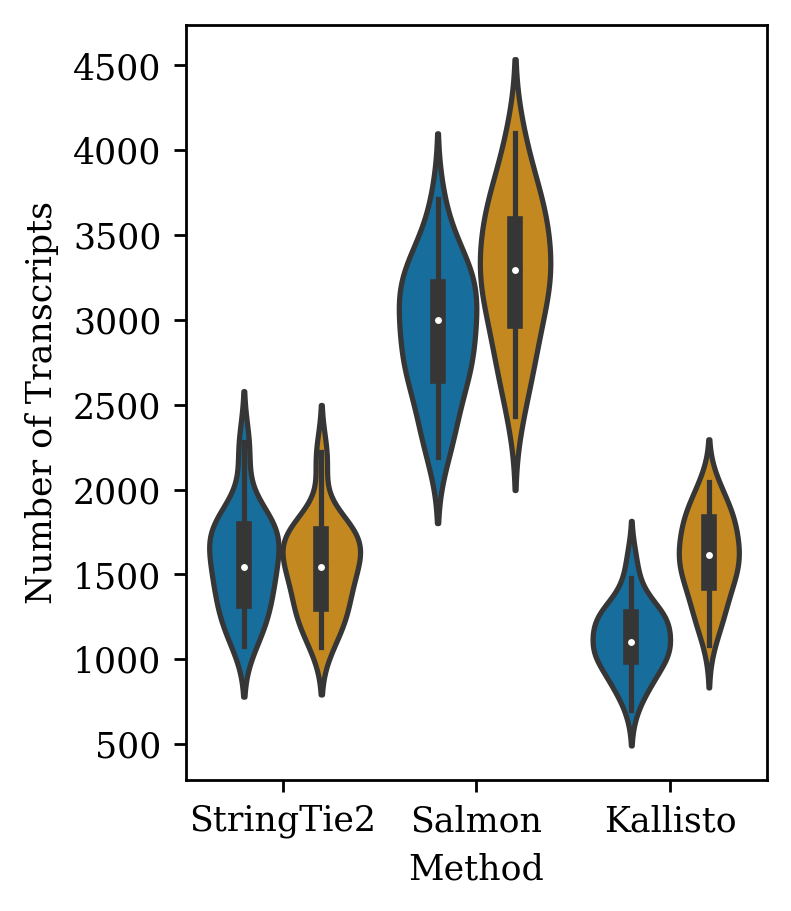

In [59]:
sub_df = df[df["type"].isin(["Real","All"])].reset_index(drop=True)
sub_df["type"]=np.where(sub_df["type"]=="Real","Without Noise","With Noise")
fig = plt.figure(figsize=(3,4),dpi=250)
ax = sns.violinplot(x="method",y="num_txs",hue="type",data=sub_df,palette="colorblind")
# ax.set_title("False Negative Rate in the Absence and \n Presence of Noisy Transcription")
ax.set_xlabel("Method")
ax.set_ylabel("Number of Transcripts")
# legend = ax.legend()
ax.legend().remove()
plt.show()

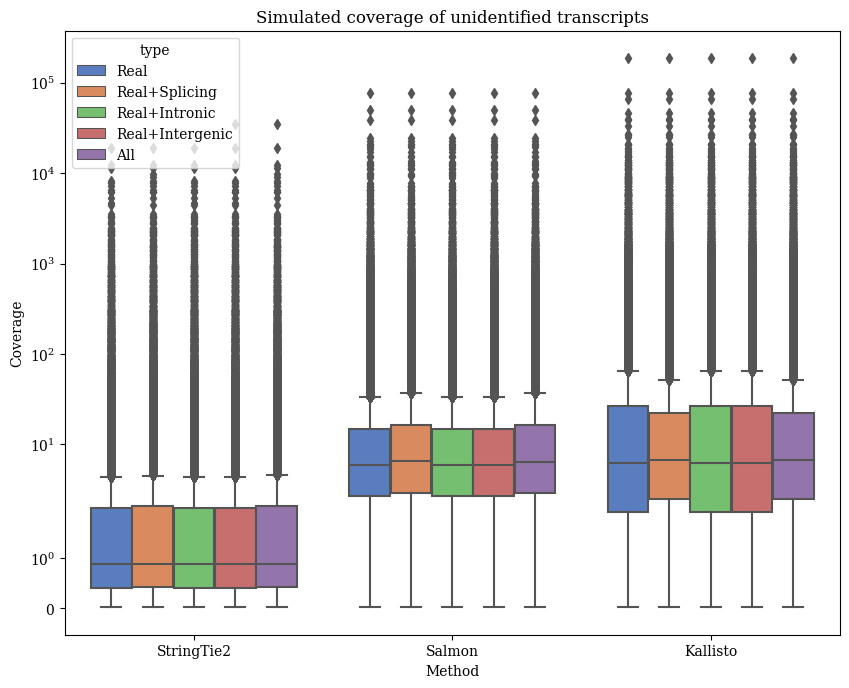

In [15]:
# plot expression values in each group
cov_strg_real = []
cov_slmn_real = []
cov_klst_real = []

cov_strg_splicing = []
cov_slmn_splicing = []
cov_klst_splicing = []

cov_strg_intronic = []
cov_slmn_intronic = []
cov_klst_intronic = []

cov_strg_intergenic = []
cov_slmn_intergenic = []
cov_klst_intergenic = []

cov_strg_all = []
cov_slmn_all = []
cov_klst_all = []

for i in range(len(sim_undetected_no_real)):
    cov_strg_real.extend(sim_undetected_no_real[i][0]["sim_cov"].tolist())
    cov_slmn_real.extend(sim_undetected_no_real[i][1]["sim_cov"].tolist())
    cov_klst_real.extend(sim_undetected_no_real[i][2]["sim_cov"].tolist())
    
    cov_strg_splicing.extend(sim_undetected_no_splicing[i][0]["sim_cov"].tolist())
    cov_slmn_splicing.extend(sim_undetected_no_splicing[i][1]["sim_cov"].tolist())
    cov_klst_splicing.extend(sim_undetected_no_splicing[i][2]["sim_cov"].tolist())
    
    cov_strg_intronic.extend(sim_undetected_no_intronic[i][0]["sim_cov"].tolist())
    cov_slmn_intronic.extend(sim_undetected_no_intronic[i][1]["sim_cov"].tolist())
    cov_klst_intronic.extend(sim_undetected_no_intronic[i][2]["sim_cov"].tolist())
    
    cov_strg_intergenic.extend(sim_undetected_no_intergenic[i][0]["sim_cov"].tolist())
    cov_slmn_intergenic.extend(sim_undetected_no_intergenic[i][1]["sim_cov"].tolist())
    cov_klst_intergenic.extend(sim_undetected_no_intergenic[i][2]["sim_cov"].tolist())
    
    cov_strg_all.extend(sim_undetected_no_all[i][0]["sim_cov"].tolist())
    cov_slmn_all.extend(sim_undetected_no_all[i][1]["sim_cov"].tolist())
    cov_klst_all.extend(sim_undetected_no_all[i][2]["sim_cov"].tolist())
    
tmp = pd.DataFrame(cov_strg_real,columns=["cov"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real"
df_cov = tmp.copy(deep=True)
tmp = pd.DataFrame(cov_strg_splicing,columns=["cov"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Splicing"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_strg_intronic,columns=["cov"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intronic"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_strg_intergenic,columns=["cov"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intergenic"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_strg_all,columns=["cov"])
tmp["method"] = "StringTie2"
tmp["type"] = "All"
df_cov = pd.concat([df_cov,tmp],axis=0)

tmp = pd.DataFrame(cov_slmn_real,columns=["cov"])
tmp["method"] = "Salmon"
tmp["type"] = "Real"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_slmn_splicing,columns=["cov"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Splicing"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_slmn_intronic,columns=["cov"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intronic"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_slmn_intergenic,columns=["cov"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intergenic"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_slmn_all,columns=["cov"])
tmp["method"] = "Salmon"
tmp["type"] = "All"
df_cov = pd.concat([df_cov,tmp],axis=0)

tmp = pd.DataFrame(cov_klst_real,columns=["cov"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_klst_splicing,columns=["cov"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Splicing"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_klst_intronic,columns=["cov"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intronic"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_klst_intergenic,columns=["cov"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intergenic"
df_cov = pd.concat([df_cov,tmp],axis=0)
tmp = pd.DataFrame(cov_klst_all,columns=["cov"])
tmp["method"] = "Kallisto"
tmp["type"] = "All"
df_cov = pd.concat([df_cov,tmp],axis=0)

df_cov.reset_index(drop=True)

fig = plt.figure(figsize=(10,8),dpi=100)
ax = sns.boxplot(x="method",y="cov",hue="type",data=df_cov,palette="muted")
ax.set_yscale("symlog")
ax.set_title("Simulated coverage of unidentified transcripts")
ax.set_xlabel("Method")
ax.set_ylabel("Coverage")
plt.show()

In [16]:
avg_strg_real = df_cov[(df_cov["method"]=="StringTie2")&(df_cov["type"]=="Real")]["cov"].median()
avg_slmn_real = df_cov[(df_cov["method"]=="Salmon")&(df_cov["type"]=="Real")]["cov"].median()
avg_klst_real = df_cov[(df_cov["method"]=="Kallisto")&(df_cov["type"]=="Real")]["cov"].median()

for tp in set(df_cov["type"]):
    if not tp=="Real":
        print("\n==== "+tp+" ====\n")
        avg_strg_tp = df_cov[(df_cov["method"]=="StringTie2")&(df_cov["type"]==tp)]["cov"].median()
        avg_slmn_tp = df_cov[(df_cov["method"]=="Salmon")&(df_cov["type"]==tp)]["cov"].median()
        avg_klst_tp = df_cov[(df_cov["method"]=="Kallisto")&(df_cov["type"]==tp)]["cov"].median()
        
        ch_strg = round(((avg_strg_tp-avg_strg_real)/avg_strg_real)*100,2)
        ch_slmn = round(((avg_slmn_tp-avg_slmn_real)/avg_slmn_real)*100,2)
        ch_klst = round(((avg_klst_tp-avg_klst_real)/avg_klst_real)*100,2)
        
        print("StringTie2: %change: "+str(ch_strg)+" : real: "+str(round(avg_strg_real,2))+" : new: "+str(round(avg_strg_tp,2)))
        print("Salmon: %change: "+str(ch_slmn)+" : real: "+str(round(avg_slmn_real,2))+" : new: "+str(round(avg_slmn_tp,2)))
        print("Kallisto: %change: "+str(ch_klst)+" : real: "+str(round(avg_klst_real,2))+" : new: "+str(round(avg_klst_tp,2)))


==== Real+Intergenic ====

StringTie2: %change: 0.0 : real: 0.89 : new: 0.89
Salmon: %change: -0.16 : real: 5.88 : new: 5.87
Kallisto: %change: 0.01 : real: 6.3 : new: 6.3

==== Real+Splicing ====

StringTie2: %change: 0.31 : real: 0.89 : new: 0.89
Salmon: %change: 10.22 : real: 5.88 : new: 6.48
Kallisto: %change: 5.95 : real: 6.3 : new: 6.68

==== All ====

StringTie2: %change: 0.36 : real: 0.89 : new: 0.89
Salmon: %change: 10.12 : real: 5.88 : new: 6.48
Kallisto: %change: 6.02 : real: 6.3 : new: 6.68

==== Real+Intronic ====

StringTie2: %change: 0.03 : real: 0.89 : new: 0.89
Salmon: %change: 0.06 : real: 5.88 : new: 5.89
Kallisto: %change: -0.1 : real: 6.3 : new: 6.3


In [17]:
for tp in set(df_cov["type"]):
    print("\n==== "+tp+" ====\n")
    strg_tp = len(df_cov[(df_cov["method"]=="StringTie2")&(df_cov["type"]==tp)&(df_cov["cov"]>1)]["cov"])
    slmn_tp = len(df_cov[(df_cov["method"]=="Salmon")&(df_cov["type"]==tp)&(df_cov["cov"]>1)]["cov"])
    klst_tp = len(df_cov[(df_cov["method"]=="Kallisto")&(df_cov["type"]==tp)&(df_cov["cov"]>1)]["cov"])

    print("StringTie2: number FP >1 reads per base: "+str(strg_tp))
    print("Salmon: number FP >1 reads per base: "+str(slmn_tp))
    print("Kallisto: number FP >1 reads per base: "+str(klst_tp))


==== Real ====

StringTie2: number FP >1 reads per base: 21678
Salmon: number FP >1 reads per base: 80620
Kallisto: number FP >1 reads per base: 28226

==== Real+Intergenic ====

StringTie2: number FP >1 reads per base: 21680
Salmon: number FP >1 reads per base: 80697
Kallisto: number FP >1 reads per base: 28230

==== Real+Splicing ====

StringTie2: number FP >1 reads per base: 21427
Salmon: number FP >1 reads per base: 91411
Kallisto: number FP >1 reads per base: 42668

==== All ====

StringTie2: number FP >1 reads per base: 21447
Salmon: number FP >1 reads per base: 91381
Kallisto: number FP >1 reads per base: 42655

==== Real+Intronic ====

StringTie2: number FP >1 reads per base: 21685
Salmon: number FP >1 reads per base: 80815
Kallisto: number FP >1 reads per base: 28252


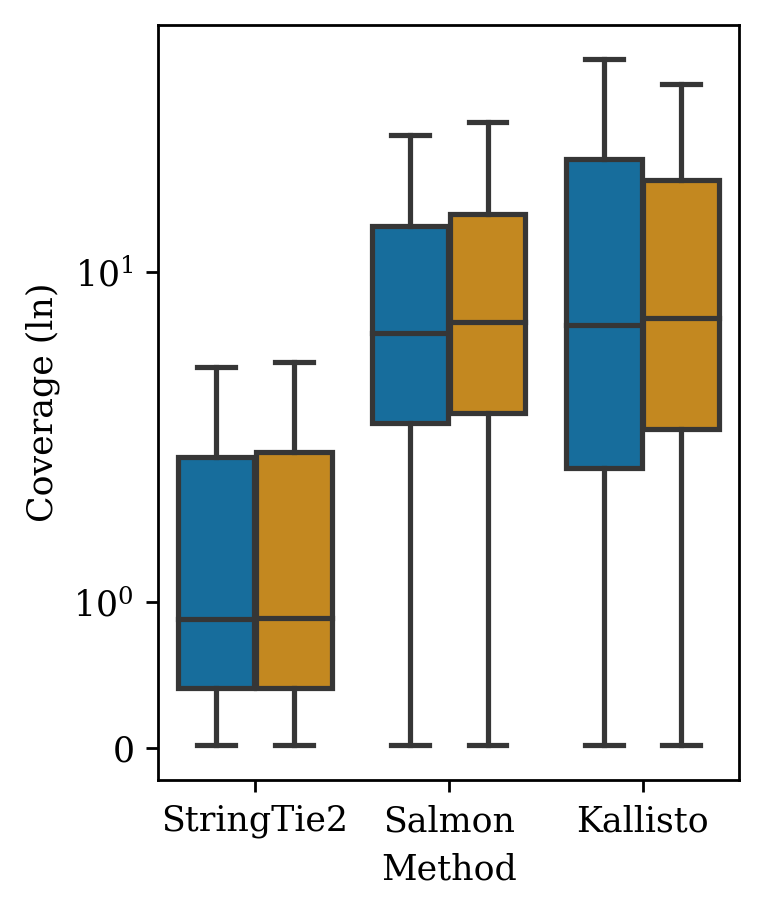

In [63]:
sub_df = df_cov[df_cov["type"].isin(["Real","All"])].reset_index(drop=True)
sub_df["type"]=np.where(sub_df["type"]=="Real","Without Noise","With Noise")
fig = plt.figure(figsize=(3,4),dpi=250)
ax = sns.boxplot(x="method",y="cov",hue="type",data=sub_df,palette="colorblind",showfliers=False)
ax.set_yscale("symlog")
# ax.set_title("Estimated Expression of False Positives \n in the Absence and Presence of Noise")
ax.set_xlabel("Method")
ax.set_ylabel("Coverage (ln)")
legend = ax.legend()
# plt.legend(loc='upper left')
ax.legend().remove()
plt.show()

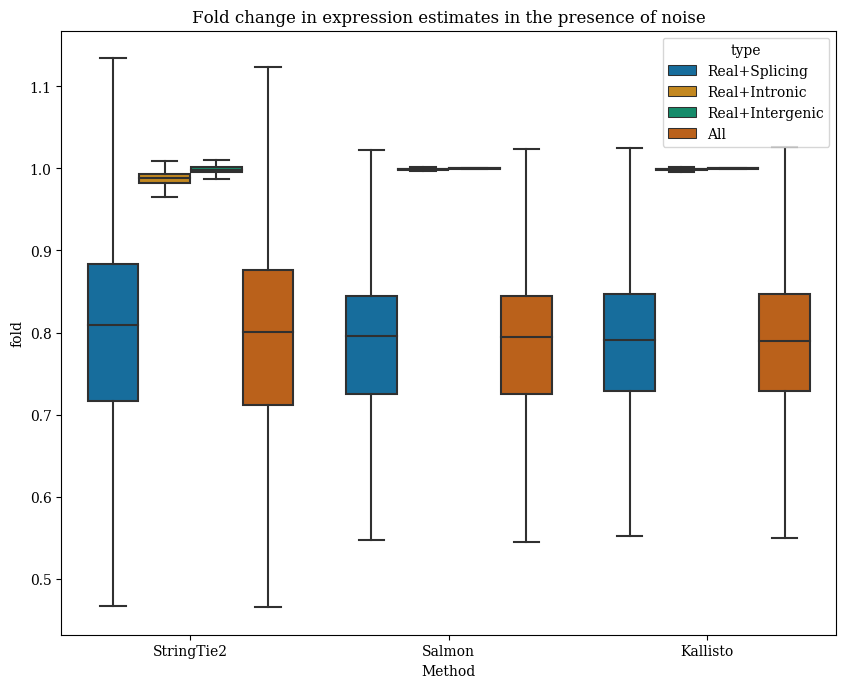

In [19]:
fold_strg_splicing = []
fold_slmn_splicing = []
fold_klst_splicing = []

fold_strg_intronic = []
fold_slmn_intronic = []
fold_klst_intronic = []

fold_strg_intergenic = []
fold_slmn_intergenic = []
fold_klst_intergenic = []

fold_strg_all = []
fold_slmn_all = []
fold_klst_all = []

for i in range(len(detected_fold_splicing)):
    fold_strg_splicing.extend(detected_fold_splicing[i][0]["strg_fold_splicing"].tolist())
    fold_slmn_splicing.extend(detected_fold_splicing[i][1]["slmn_fold_splicing"].tolist())
    fold_klst_splicing.extend(detected_fold_splicing[i][2]["klst_fold_splicing"].tolist())
    
    fold_strg_intronic.extend(detected_fold_intronic[i][0]["strg_fold_intronic"].tolist())
    fold_slmn_intronic.extend(detected_fold_intronic[i][1]["slmn_fold_intronic"].tolist())
    fold_klst_intronic.extend(detected_fold_intronic[i][2]["klst_fold_intronic"].tolist())
    
    fold_strg_intergenic.extend(detected_fold_intergenic[i][0]["strg_fold_intergenic"].tolist())
    fold_slmn_intergenic.extend(detected_fold_intergenic[i][1]["slmn_fold_intergenic"].tolist())
    fold_klst_intergenic.extend(detected_fold_intergenic[i][2]["klst_fold_intergenic"].tolist())
    
    fold_strg_all.extend(detected_fold_all[i][0]["strg_fold_all"].tolist())
    fold_slmn_all.extend(detected_fold_all[i][1]["slmn_fold_all"].tolist())
    fold_klst_all.extend(detected_fold_all[i][2]["klst_fold_all"].tolist())

tmp = pd.DataFrame(fold_strg_splicing,columns=["fold"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Splicing"
df_fold = tmp.copy(deep=True)
tmp = pd.DataFrame(fold_strg_intronic,columns=["fold"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intronic"
df_fold = pd.concat([df_fold,tmp],axis=0)
tmp = pd.DataFrame(fold_strg_intergenic,columns=["fold"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intergenic"
df_fold = pd.concat([df_fold,tmp],axis=0)
tmp = pd.DataFrame(fold_strg_all,columns=["fold"])
tmp["method"] = "StringTie2"
tmp["type"] = "All"
df_fold = pd.concat([df_fold,tmp],axis=0)

tmp = pd.DataFrame(fold_slmn_splicing,columns=["fold"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Splicing"
df_fold = pd.concat([df_fold,tmp],axis=0)
tmp = pd.DataFrame(fold_slmn_intronic,columns=["fold"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intronic"
df_fold = pd.concat([df_fold,tmp],axis=0)
tmp = pd.DataFrame(fold_slmn_intergenic,columns=["fold"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intergenic"
df_fold = pd.concat([df_fold,tmp],axis=0)
tmp = pd.DataFrame(fold_slmn_all,columns=["fold"])
tmp["method"] = "Salmon"
tmp["type"] = "All"
df_fold = pd.concat([df_fold,tmp],axis=0)

tmp = pd.DataFrame(fold_klst_splicing,columns=["fold"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Splicing"
df_fold = pd.concat([df_fold,tmp],axis=0)
tmp = pd.DataFrame(fold_klst_intronic,columns=["fold"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intronic"
df_fold = pd.concat([df_fold,tmp],axis=0)
tmp = pd.DataFrame(fold_klst_intergenic,columns=["fold"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intergenic"
df_fold = pd.concat([df_fold,tmp],axis=0)
tmp = pd.DataFrame(fold_klst_all,columns=["fold"])
tmp["method"] = "Kallisto"
tmp["type"] = "All"
df_fold = pd.concat([df_fold,tmp],axis=0)

df_fold.reset_index(drop=True)

fig = plt.figure(figsize=(10,8),dpi=100)
ax = sns.boxplot(x="method",y="fold",hue="type",data=df_fold,palette="colorblind",showfliers=False)
# ax.set_yscale("symlog")
ax.set_title("Fold change in expression estimates in the presence of noise")
ax.set_xlabel("Method")
ax.set_ylabel("fold")
plt.show()

In [20]:
for tp in set(df_fold["type"]):
    print("\n==== "+tp+" ====\n")
    strg_tp = df_fold[(df_fold["method"]=="StringTie2")&(df_fold["type"]==tp)]["fold"].median()
    slmn_tp = df_fold[(df_fold["method"]=="Salmon")&(df_fold["type"]==tp)]["fold"].median()
    klst_tp = df_fold[(df_fold["method"]=="Kallisto")&(df_fold["type"]==tp)]["fold"].median()

    print("StringTie2: median: "+str(strg_tp))
    print("Salmon: median: "+str(slmn_tp))
    print("Kallisto: median: "+str(klst_tp))


==== All ====

StringTie2: median: 0.8000654933990278
Salmon: median: 0.7945884773423418
Kallisto: median: 0.7899334867342203

==== Real+Intronic ====

StringTie2: median: 0.9879188945937385
Salmon: median: 0.9993200048082714
Kallisto: median: 0.9991175351844809

==== Real+Splicing ====

StringTie2: median: 0.8088468751217154
Salmon: median: 0.7951641402940814
Kallisto: median: 0.7905226053639847

==== Real+Intergenic ====

StringTie2: median: 0.998686533328738
Salmon: median: 0.9999610623749825
Kallisto: median: 0.9999421119862921


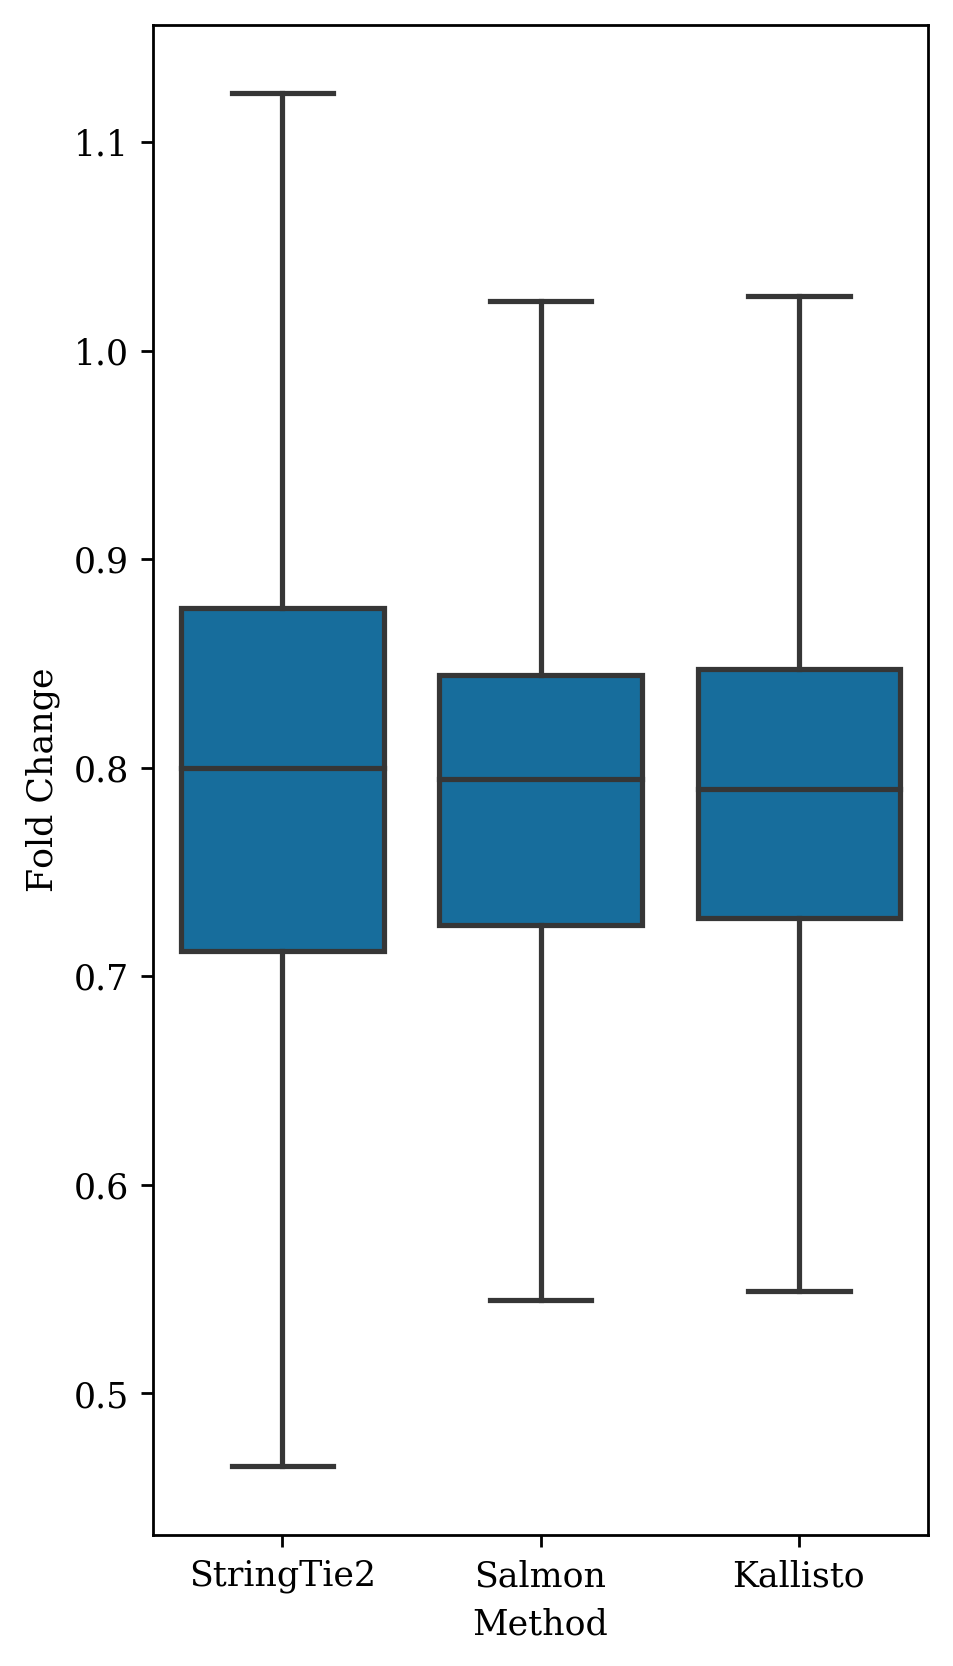

In [58]:
sub_df = df_fold[df_fold["type"].isin(["All"])].reset_index(drop=True)
sub_df["type"]=np.where(sub_df["type"]=="Real","Without Noise","With Noise")
fig = plt.figure(figsize=(4,8),dpi=250)
ax = sns.boxplot(x="method",y="fold",hue="type",data=sub_df,palette="colorblind",showfliers=False)
# ax.set_title("Fold Change in Expression Estimates \n in the Presence of Noise")
ax.set_xlabel("Method")
ax.set_ylabel("Fold Change")
ax.legend().remove()
plt.show()

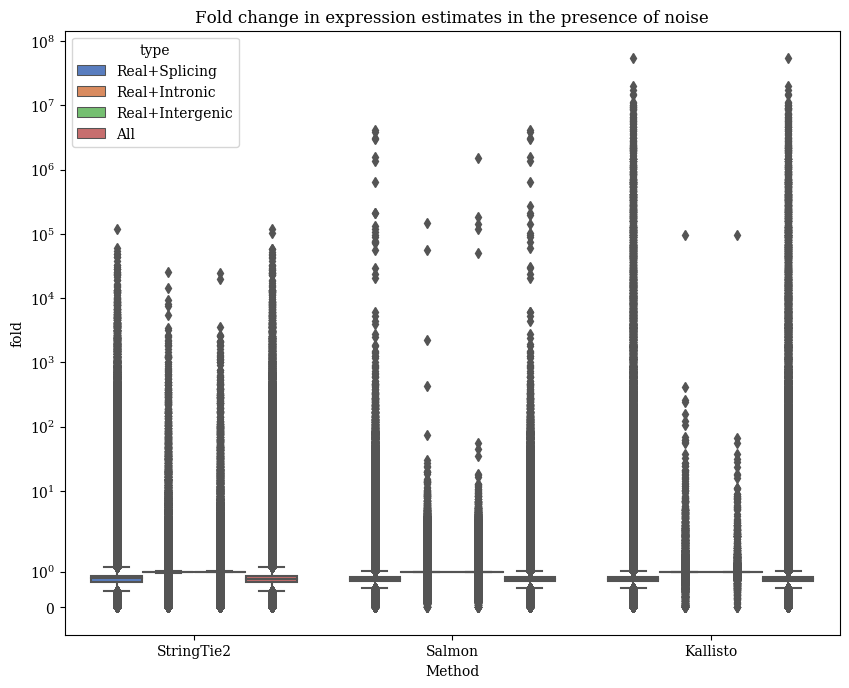

In [141]:
fig = plt.figure(figsize=(10,8),dpi=100)
ax = sns.boxplot(x="method",y="fold",hue="type",data=df_fold,palette="muted")
ax.set_yscale("symlog")
ax.set_title("Fold change in expression estimates in the presence of noise")
ax.set_xlabel("Method")
ax.set_ylabel("fold")
plt.show()

In [171]:
# same plot but fold change compared to the truth (sim_n_reads)

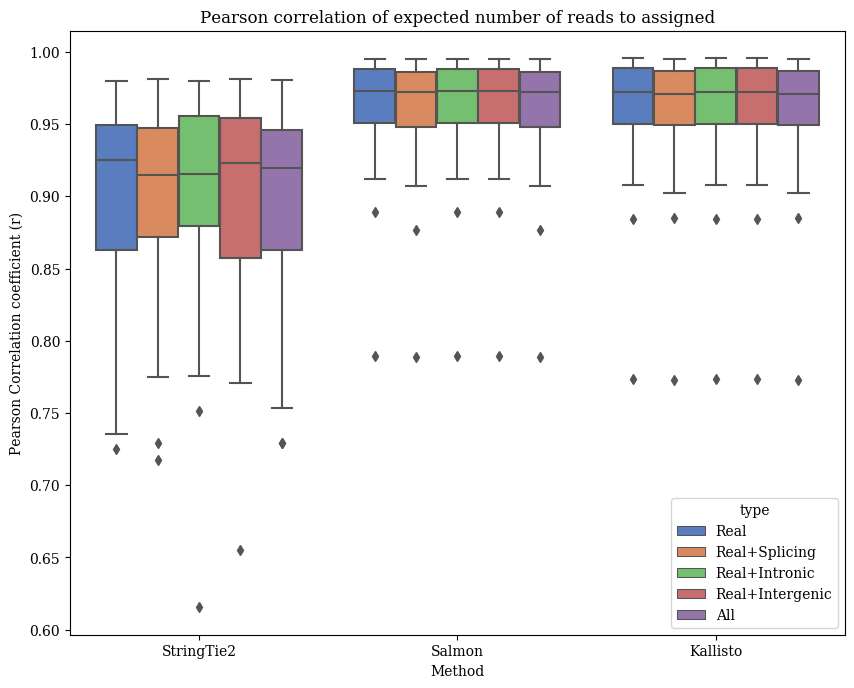

In [142]:
# plot the number of transcripts in each group
r_strg_real = []
r_slmn_real = []
r_klst_real = []

r_strg_splicing = []
r_slmn_splicing = []
r_klst_splicing = []

r_strg_intronic = []
r_slmn_intronic = []
r_klst_intronic = []

r_strg_intergenic = []
r_slmn_intergenic = []
r_klst_intergenic = []

r_strg_all = []
r_slmn_all = []
r_klst_all = []

for i in range(len(detected_r_real)):
    r_strg_real.append(detected_r_real[i][0])
    r_slmn_real.append(detected_r_real[i][1])
    r_klst_real.append(detected_r_real[i][2])
    
    r_strg_splicing.append(detected_r_splicing[i][0])
    r_slmn_splicing.append(detected_r_splicing[i][1])
    r_klst_splicing.append(detected_r_splicing[i][2])
    
    r_strg_intronic.append(detected_r_intronic[i][0])
    r_slmn_intronic.append(detected_r_intronic[i][1])
    r_klst_intronic.append(detected_r_intronic[i][2])
    
    r_strg_intergenic.append(detected_r_intergenic[i][0])
    r_slmn_intergenic.append(detected_r_intergenic[i][1])
    r_klst_intergenic.append(detected_r_intergenic[i][2])
    
    r_strg_all.append(detected_r_all[i][0])
    r_slmn_all.append(detected_r_all[i][1])
    r_klst_all.append(detected_r_all[i][2])
    
tmp = pd.DataFrame(r_strg_real,columns=["r"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real"
df = tmp.copy(deep=True)
tmp = pd.DataFrame(r_strg_splicing,columns=["r"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_strg_intronic,columns=["r"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_strg_intergenic,columns=["r"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_strg_all,columns=["r"])
tmp["method"] = "StringTie2"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

tmp = pd.DataFrame(r_slmn_real,columns=["r"])
tmp["method"] = "Salmon"
tmp["type"] = "Real"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_slmn_splicing,columns=["r"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_slmn_intronic,columns=["r"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_slmn_intergenic,columns=["r"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_slmn_all,columns=["r"])
tmp["method"] = "Salmon"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

tmp = pd.DataFrame(r_klst_real,columns=["r"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_klst_splicing,columns=["r"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_klst_intronic,columns=["r"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_klst_intergenic,columns=["r"])
tmp["method"] = "Kallisto"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(r_klst_all,columns=["r"])
tmp["method"] = "Kallisto"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

df.reset_index(drop=True)

fig = plt.figure(figsize=(10,8),dpi=100)
ax = sns.boxplot(x="method",y="r",hue="type",data=df,palette="muted")
ax.set_title("Pearson correlation of expected number of reads to assigned")
ax.set_xlabel("Method")
ax.set_ylabel("Pearson Correlation coefficient (r)")
plt.show()

In [143]:
# next we need a plot of gene-level expression estimation
# this can be done as a fold-change plot
# where the fold-change is computed between gene-level TPM of combined real-only transcripts
# and the combined TPM estimated by each method




In [ ]:
# the other plot which would be beneficial for the paper is fold change as a function of the fraction of noise reads
# this would be easy to do at the gene-level
# however, it would also be informative to do on the transcript level
# which requires us to know which noisy reads overlap which real transcripts (full containment or not)
# since this is a complex question, perhaps exploring it on the gene-level will be better

In [144]:
for i in range(len(detected_r_splicing)):
    print(i,detected_r_splicing[i])

0 [0.9204343134375803, 0.9838630886164709, 0.9835565117252613]
1 [0.9577282662099043, 0.9865640218125117, 0.986678883366883]
2 [0.9621652470758039, 0.9775351198623076, 0.9779247113172485]
3 [0.9118277048672023, 0.9610452309853629, 0.9613815710144008]
4 [0.9476432427064668, 0.9488138588613527, 0.948536773052402]
5 [0.9068831707913516, 0.9948420526207657, 0.995325546680069]
6 [0.9809727955606871, 0.9789138458691915, 0.980443792253862]
7 [0.8344971080373046, 0.9947095117777889, 0.9951089628110322]
8 [0.8078108391127556, 0.9942318451436071, 0.9945121496470292]
9 [0.9675330412499438, 0.969047901223463, 0.9681872847263433]
10 [0.7882741961934129, 0.9071337142330074, 0.9026014559295983]
11 [0.8696187914781565, 0.9772938217820709, 0.982078495349041]
12 [0.9246207490215386, 0.9925344708920534, 0.9920841908503124]
13 [0.9359703366608165, 0.9922143804451806, 0.991863672121502]
14 [0.9711595109424693, 0.98555538997896, 0.9856983631858179]
15 [0.9773689513753683, 0.9878902386343746, 0.9891591341708

In [145]:
tissue_num = 2
sample_num = 0
all_df = pd.read_csv(out_dir+"real_splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".res")

all_df["sim_cov"] = (readlen*all_df["sim_nreads"])/all_df["elen"]

# merge and compute fold_change in TPM
merge_df = all_df[["tid","sim_nreads","sim_cov","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]]
merge_df.columns = ["tid",
                    "sim_nreads",
                    "sim_cov",
                    "strg_tpm_all",
                    "strg_nreads_all",
                    "slmn_tpm_all",
                    "slmn_nreads_all",
                    "klst_tpm_all",
                    "klst_nreads_all"]

# # first how many transcripts are identified by each method that were not in the sample
# strg = merge_df[(merge_df["strg_tpm_all"]>0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_all"]].reset_index(drop=True)
# slmn = merge_df[(merge_df["slmn_tpm_all"]>0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_all"]].reset_index(drop=True)
# klst = merge_df[(merge_df["klst_tpm_all"]>0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_all"]].reset_index(drop=True)


# # next get information about those that were not identified at all (but were present in the real)
# strg = merge_df[(merge_df["strg_tpm_all"]==0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_all","sim_cov"]].reset_index(drop=True)
# slmn = merge_df[(merge_df["slmn_tpm_all"]==0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_all","sim_cov"]].reset_index(drop=True)
# klst = merge_df[(merge_df["klst_tpm_all"]==0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_all","sim_cov"]].reset_index(drop=True)

strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_nreads_all"]>0)][["tid","sim_nreads","strg_nreads_all"]].reset_index(drop=True)
slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_nreads_all"]>0)][["tid","sim_nreads","slmn_nreads_all"]].reset_index(drop=True)
klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_nreads_all"]>0)][["tid","sim_nreads","klst_nreads_all"]].reset_index(drop=True)
detected_r_all.append(list())
strg = stats.linregress(strg_df["sim_nreads"],strg_df["strg_nreads_all"]).rvalue
slmn = stats.linregress(slmn_df["sim_nreads"],slmn_df["slmn_nreads_all"]).rvalue
klst = stats.linregress(klst_df["sim_nreads"],klst_df["klst_nreads_all"]).rvalue
print(strg,slmn,klst)

strg = strg_df["sim_nreads"].corr(strg_df["strg_nreads_all"])
slmn = slmn_df["sim_nreads"].corr(slmn_df["slmn_nreads_all"])
klst = klst_df["sim_nreads"].corr(klst_df["klst_nreads_all"])
print(strg,slmn,klst)

0.8914360403524846 0.9140938261333575 0.9084110571478701
0.8914360403524845 0.9140938261333575 0.9084110571478701


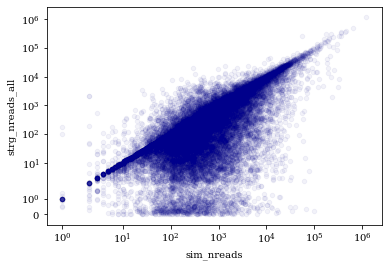

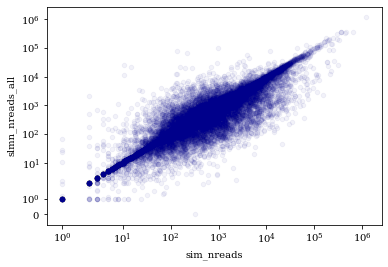

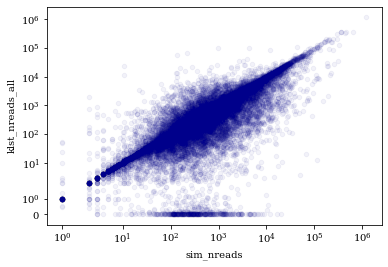

In [146]:
strg_df.plot.scatter(x='sim_nreads',
                      y='strg_nreads_all',
                      c='DarkBlue',alpha=0.05)
plt.yscale("symlog")
plt.xscale("symlog")

slmn_df.plot.scatter(x='sim_nreads',
                      y='slmn_nreads_all',
                      c='DarkBlue',alpha=0.05)
plt.yscale("symlog")
plt.xscale("symlog")

klst_df.plot.scatter(x='sim_nreads',
                      y='klst_nreads_all',
                      c='DarkBlue',alpha=0.05)
plt.yscale("symlog")
plt.xscale("symlog")

In [147]:
slmn_df[slmn_df["tid"]=="CHS.60410.1"]

,tid,sim_nreads,slmn_nreads_all
0,CHS.60410.1,43,287.402008


In [148]:
slmn_df.sort_values(by="slmn_nreads_all")

,tid,sim_nreads,slmn_nreads_all
9284,CHS.21459.1,326,1.000000e-03
6899,CHS.43350.2,8,1.000000e+00
6474,CHS.3427.1,1,1.000000e+00
14048,CHS.19659.1,1,1.000000e+00
20158,CHS.46665.1,1,1.000000e+00
...,...,...,...
3220,CHS.17531.44,357717,3.494531e+05
15029,CHS.23430.1,364274,3.505377e+05
4603,CHS.12960.11,460536,3.659890e+05
6741,CHS.11664.9,645842,3.685210e+05


In [149]:
slmn_df[~(slmn_df["tid"]=="CHS.30573.2")]["sim_nreads"].corr(slmn_df[~(slmn_df["tid"]=="CHS.30573.2")]["slmn_nreads_all"])

0.9141010685622083

In [ ]:
# for each sample print:
# 1. number of reads
# 2. number of real transcripts
# 3. number of splicing transcripts
# 4. pearson r
# 5. number false positives
# 6. number of false negatives

In [ ]:
# next we shall look at the overall accuracy of quantification in terms of the number of reads
# the previous plot only shows the change
# however, while the change may be minor the accuracy might be very low

# this could be done by computing the correlation coefficient and plotting that instead

In [ ]:
# next we can look at the number of unidentified transcripts

In [3]:
# would be nice for internal analysis to look at the misassemblies in stringtie
# aggregate by tissue
# aggregate by ALL
# compute gtex_stats
# compare distributions to those of GTEx

# also run gffcompare against the true ALL (need to combine actual annotations together across samples and tissue)
# and look at precision and recall

In [ ]:
# lastly need to search more literature on what other plots people look at in RNA-seq anaysis
# should we perform simple DE between tissues?

In [ ]:
# perhaps investigate at what level do tools start to have significant deviations from correct measurements?

In [ ]:
# need to find out why some false negatives have such high expression....